In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
from demo_utils import ImageTransformPipeline

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%matplotlib notebook
np.set_printoptions(precision=3, linewidth=500,  threshold=500, suppress=True, edgeitems=5)

In [6]:
import sys
sys.path.append('../..')

# Graph Signal Reconstruction

<IPython.core.display.Javascript object>


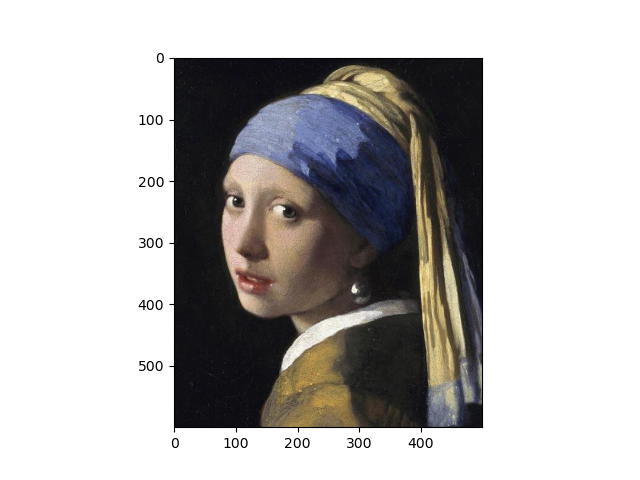

In [7]:
# Load in an image and resize

im_url = '../../data/images/image1.jpg'
im = Image.open(im_url)
im = np.array(im)

plt.figure()
plt.imshow(im)

In [8]:
# log, shift and scale the data

pipeline = ImageTransformPipeline(im)

Y0 = pipeline.transform()

<IPython.core.display.Javascript object>


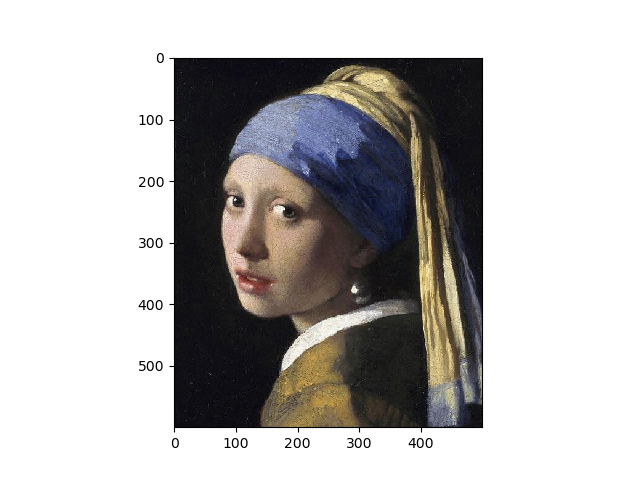

In [9]:
# generate some random noise

factor = 0.001

noise = factor * np.random.normal(size=(Y0.shape))

Y_noisy = Y0 + noise

Y_noisy_im = pipeline.reverse_transform(Y_noisy)

plt.figure()

plt.imshow(Y_noisy_im, interpolation='nearest')

In [10]:
def split_channels(im):
    
    Y_r, Y_g, Y_b = im.copy(), im.copy(), im.copy()

    Y_r[:, :, 1:] = 0
    Y_g[:, :, 0] = 0
    Y_g[:, :, 2] = 0
    Y_b[:, :, :2] = 0
    
    return Y_r, Y_g, Y_b

<IPython.core.display.Javascript object>


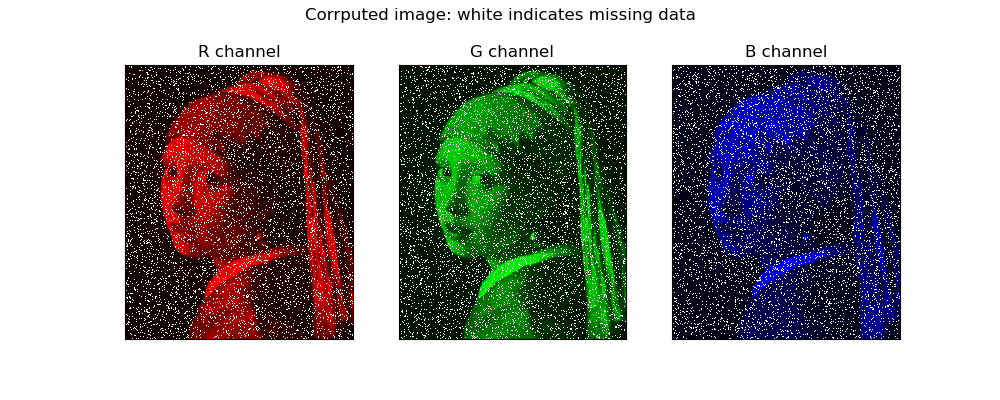

Text(0.5, 0.98, 'Corrputed image: white indicates missing data')

In [11]:
# create a sensing matrix S, and graph signal Y with 0's where data is missing

missingness = 10                        # percent

S = np.random.uniform(0, 1, Y0.shape)
S = (S > np.percentile(S, missingness))

Y = Y_noisy.copy()
Y[~S] = 0

Y_im = pipeline.reverse_transform(Y_noisy)

fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(10, 4))

Y_r, Y_g, Y_b = split_channels(Y_im)


Y_r[~np.array([S[:, :, 0]] * 3).transpose(1, 2, 0)] = 255
Y_g[~np.array([S[:, :, 1]] * 3).transpose(1, 2, 0)] = 255
Y_b[~np.array([S[:, :, 2]] * 3).transpose(1, 2, 0)] = 255

for ax, Y_i, title in zip(axes, [Y_r, Y_g, Y_b], ['R channel', 'G channel', 'B channel']):
    
#     ax.imshow(Y_i)
    ax.imshow(Y_i, interpolation='nearest')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

fig.suptitle('Corrputed image: white indicates missing data')


In [12]:
from models.reconstruction import reconstruct_graph_signal
from graph.graphs import ProductGraph
from graph.filters import UnivariateFilterFunction, MultivariateFilterFunction


In [13]:
# create a reconstructor object

graph = ProductGraph.image(Y)

filter_function = MultivariateFilterFunction.diffusion(beta=[5, 5, 0.3])
# filter_function = MultivariateFilterFunction.bandlimited(beta=[5, 5, 0.3])


mean = reconstruct_graph_signal(Y, graph, filter_function, gamma=0.001, compute_logvar=False)


<IPython.core.display.Javascript object>


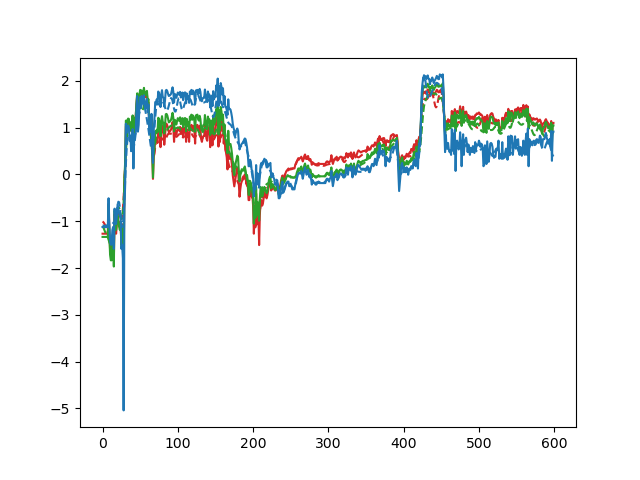

<IPython.core.display.Javascript object>


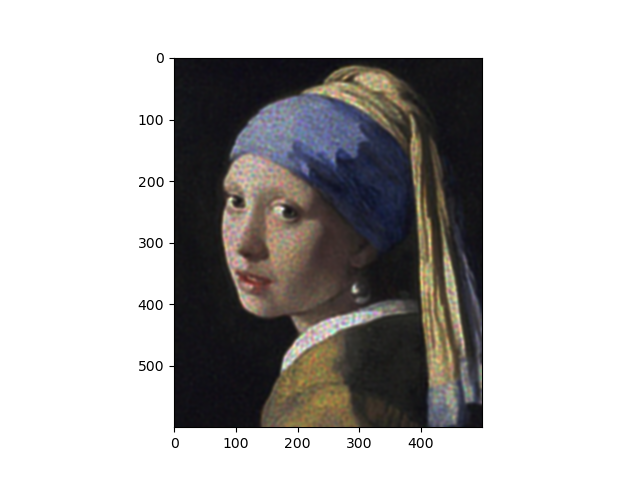

<IPython.core.display.Javascript object>


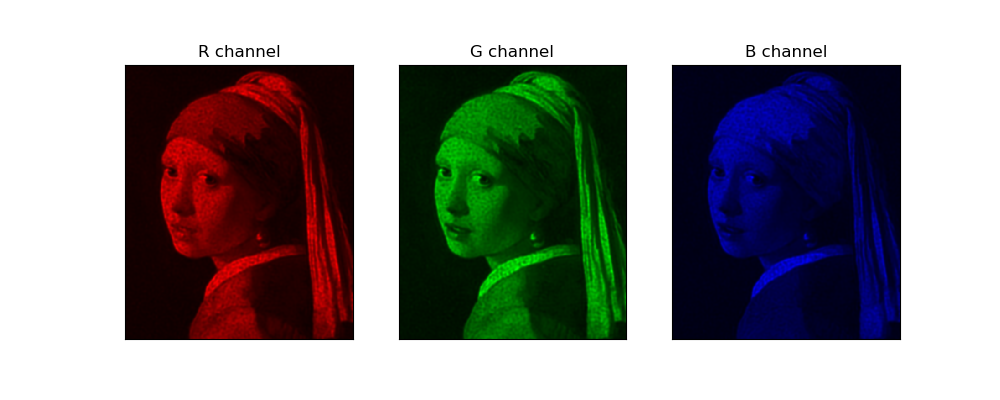

In [14]:
Y_r, Y_g, Y_b = split_channels(pipeline.reverse_transform(mean))


plt.figure()


plt.plot(Y0[:, 250, 0], color='tab:red')
plt.plot(mean[:, 250, 0], color='tab:red', ls='--')

plt.plot(Y0[:, 250, 1], color='tab:green')
plt.plot(mean[:, 250, 1], color='tab:green', ls='--')

plt.plot(Y0[:, 250, 2], color='tab:blue')
plt.plot(mean[:, 250, 2], color='tab:blue', ls='--')


plt.figure()

plt.imshow(pipeline.reverse_transform(mean), interpolation='bicubic', interpolation_stage='rgba')

fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(10, 4))



for ax, Y_i, title in zip(axes, [Y_r, Y_g, Y_b], ['R channel', 'G channel', 'B channel']):
    
    ax.imshow(Y_i, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
